In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh.plotting as bk
import bokeh.io as outbk
import bokeh
import ipywidgets as ipy
from natsort import natsorted, index_natsorted, order_by_index
import datetime as dt
import mes_fonctions as mfct
import scipy.stats as st
import math as mth


In [3]:
outbk.output_notebook() #Intégration des graphiques bokeh dans le notebook

Loading BokehJS ...

In [4]:
#Importation des fichiers csv 
df_customers = pd.read_csv('dataset_P4/customers.csv',header =0)
df_products = pd.read_csv('dataset_P4/products.csv',header =0)
df_transactions = pd.read_csv('dataset_P4/transactions.csv', header =0, parse_dates=['date']) #Converti la colonne date en Timestamp



# Mission n°1 : Nettoyage de données

Avant de pouvoir entrer dans le vif du sujet, il vous faudra faire un peu de nettoyage ! Par exemple, vous devrez faire des choix quant au traitement des valeurs manquantes et des valeurs aberrantes.

## Traitement des valeurs manquantes

In [5]:
mfct.verif_presence_nan_in_df(df_customers, namedf='customers')

Il n'y a pas de valeur manquante dans customers


In [6]:
mfct.verif_presence_nan_in_df(df_products, 'products')

Il n'y a pas de valeur manquante dans products


In [7]:
mfct.verif_presence_nan_in_df(df_transactions, 'transactions')

Il n'y a pas de valeur manquante dans transactions


## Traitement des valeurs aberrantes ou outliers (manifestement fausse) ≠ valeurs atypiques (valeur qui sort du lot mais qui n'est pas forcément fausse)

In [8]:

df_customers_retraite = df_customers.reindex(index=order_by_index(df_customers.index, index_natsorted(df_customers.client_id))) #La colonne 'client_id' est triée naturellement avec natsort
print(df_customers_retraite.tail()) #A la fin de a il y a deux valeurs aberrantes ct_0 et ct_1
df_customers_retraite = df_customers_retraite.replace(['ct_0', 'ct_1'], ['c_511', 'c_512'])
df_customers_retraite = df_customers_retraite.reset_index(drop=True)
print(df_customers_retraite.head())

    client_id sex  birth
315     c_508   m   1979
282     c_509   f   1961
472     c_510   f   1955
93       ct_0   f   2001
449      ct_1   m   2001
  client_id sex  birth
0       c_1   f   1988
1       c_2   f   1942
2       c_3   f   1989
3       c_4   f   1984
4       c_5   m   1965


In [9]:
df_customers['sex'].value_counts()

f    262
m    250
Name: sex, dtype: int64

In [10]:
a = df_customers.sort_values(by = 'birth')
effectifs_age_customers = a['birth'].value_counts()
modalites_age_customers = effectifs_age_customers.index
distribution_empirique_age_customers = pd.DataFrame(modalites_age_customers, columns =['birth'])
distribution_empirique_age_customers['n'] = effectifs_age_customers.values
distribution_empirique_age_customers['f'] = distribution_empirique_age_customers['n'] / len(df_customers)
distribution_empirique_age_customers = distribution_empirique_age_customers.sort_values('birth')
distribution_empirique_age_customers['F'] = distribution_empirique_age_customers['f'].cumsum()


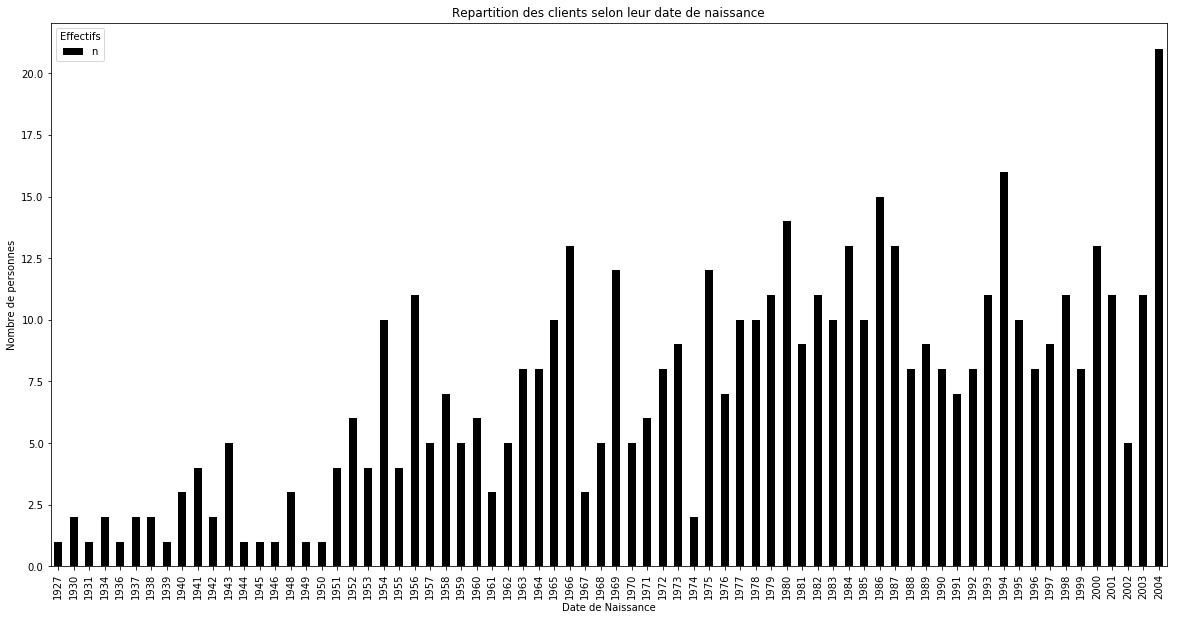

In [11]:
plot_distribution_empirique_age_customers =distribution_empirique_age_customers.plot(x='birth',y='n',kind='bar', figsize=(20,10), colormap='copper')
plt.title('Repartition des clients selon leur date de naissance')
plt.legend(title='Effectifs', loc='upper left')
plt.ylabel('Nombre de personnes')
plt.xlabel('Date de Naissance')
plt.show(plot_distribution_empirique_age_customers)
image= plot_distribution_empirique_age_customers.get_figure()
image.savefig('Images/Repartition des clients selon leur date de naissance')

L'axe des abscisses ne représente pas toutes les années allant de 1927 à 2004
Il y a une consommatrice qui a 95 ans (2022-1927). L'espérance de vie d'une femme est de 84.5 ans (http://www.observationsociete.fr/population/evolution-esperance-de-vie.html). Il s'agit d'une valeur atypique que nous allons conserver.

### Conclusion traitement valeurs aberrantes 'df_customers'
Il n'y avait que les codes clients à uniformiser. Nous utiliserons df_customers_retraite' pour l'analyse.

In [12]:
df_products_retraite = df_products.reindex(index=order_by_index(df_products.index, index_natsorted(df_products.id_prod))) 
print(df_products_retraite.tail(10)) #A la fin il faut supprimer le code faux avec le prix negatif
df_products_retraite = df_products_retraite.drop(407)
df_products_retraite = df_products_retraite.reset_index(drop=True)
print(df_products_retraite.head())


     id_prod   price  categ
1771   2_230  190.57      2
2178   2_231   85.39      2
2086   2_232   99.20      2
1818   2_233   59.98      2
800    2_234   65.06      2
2851   2_235  263.19      2
815    2_236   46.22      2
755    2_237   79.73      2
2796   2_238   41.70      2
407      T_0   -1.00      0
  id_prod  price  categ
0     0_0  17.33      0
1     0_1   7.91      0
2     0_2  21.68      0
3     0_3   1.88      0
4     0_4   7.22      0


In [13]:
#Vérification qu'il m'y a pas de valeur négative
s = df_products_retraite['price'] < 0
s.value_counts()

False    3286
Name: price, dtype: int64

In [14]:
#Vérification qu'il m'y a pas de valeur négative
s = df_products_retraite['categ'] < 0
s.value_counts()

False    3286
Name: categ, dtype: int64

In [15]:
df_products_retraite[df_products_retraite['id_prod']=='1_372'] # Ce produit n'existe pas dans df_product mais il existe dans df_trans
df_add_product_1_372 = pd.DataFrame([{'id_prod':'1_372','price': 25 ,'categ':1}])#On impute le prix de ce produit de 25e soit la moyenne des prix de cat 1

df_products_retraite_2 =df_products_retraite.append(df_add_product_1_372, ignore_index=True)
df_products_retraite_2.head(10)

,categ,id_prod,price
0,0,0_0,17.33
1,0,0_1,7.91
2,0,0_2,21.68
3,0,0_3,1.88
4,0,0_4,7.22
5,0,0_5,16.76
6,0,0_6,3.75
7,0,0_7,18.14
8,0,0_8,18.94
9,0,0_9,12.41


### Conclusion valeur aberrantes 'df_products'
Nous avons supprimé une ligne contenant des valeurs aberrantes.

In [16]:
df_transactions_retraite = df_transactions.reindex(index=order_by_index(df_transactions.index, index_natsorted(df_transactions.id_prod)))
print(df_transactions_retraite.tail(10))
df_transactions_retraite = df_transactions_retraite[df_transactions_retraite.id_prod != 'T_0'] #Suppression des lignes test
print(df_transactions_retraite.dtypes)
df_transactions_retraite['date'] = df_transactions_retraite['date'].map(lambda x: str(x)[:-7]) #Suppression des nanosecondes
df_transactions_retraite['date'] = pd.to_datetime(df_transactions_retraite['date'], format='%Y-%m-%d %H:%M:%S') #Conversion des valeurs en format date (car l'opération à échoué lors de l'opération "The default date parser works on many common date formats, but dates can come in a lot different forms.")
print(df_transactions_retraite.dtypes)
df_transactions_retraite = df_transactions_retraite.reset_index(drop=True)
print(df_transactions_retraite.head())


#Filtrer par date

a = df_transactions_retraite.sort_values(by='date')
df_transactions_retraite_2 = a[(a['date'] < '2021-09-30')|(a['date'] > '2021-11-01')]
df_transactions_retraite_2


       id_prod                             date session_id client_id
327370     T_0  test_2021-03-01 02:30:02.237442        s_0      ct_1
328618     T_0  test_2021-03-01 02:30:02.237416        s_0      ct_1
328706     T_0  test_2021-03-01 02:30:02.237418        s_0      ct_0
328852     T_0  test_2021-03-01 02:30:02.237439        s_0      ct_1
332736     T_0  test_2021-03-01 02:30:02.237431        s_0      ct_0
336158     T_0  test_2021-03-01 02:30:02.237430        s_0      ct_0
336650     T_0  test_2021-03-01 02:30:02.237447        s_0      ct_0
338550     T_0  test_2021-03-01 02:30:02.237421        s_0      ct_1
339325     T_0  test_2021-03-01 02:30:02.237446        s_0      ct_1
340613     T_0  test_2021-03-01 02:30:02.237447        s_0      ct_0
id_prod       object
date          object
session_id    object
client_id     object
dtype: object
id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
dtype: object
  id_prod    

,id_prod,date,session_id,client_id
1662,0_57,2021-03-01 00:01:33,s_1,c_106
53778,0_1250,2021-03-01 00:02:46,s_2,c_10
139618,0_1519,2021-03-01 00:04:49,s_3,c_163
250663,1_372,2021-03-01 00:05:47,s_4,c_52
43610,0_1170,2021-03-01 00:07:49,s_5,c_400
75559,0_1351,2021-03-01 00:11:37,s_6,c_129
78774,0_1358,2021-03-01 00:12:19,s_1,c_174
62353,0_1310,2021-03-01 00:13:21,s_1,c_255
25127,0_1073,2021-03-01 00:15:17,s_7,c_316
267882,1_418,2021-03-01 00:17:08,s_8,c_508


### Conclusion valeur aberrantes 'df_transactions'
L'ensemble des lignes 'test' a été supprimé. Le format de date a été changé pour faciliter les travaux.

## Test supplémentaire suite à jointure df_product et df_transaction

In [17]:
jointure = pd.merge(df_products_retraite, df_transactions_retraite, 'outer') 
jointure

,id_prod,price,categ,date,session_id,client_id
0,0_0,17.33,0.0,2021-03-16 15:33:49,s_467,c_54
1,0_0,17.33,0.0,2022-01-10 21:46:34,s_8774,c_223
2,0_0,17.33,0.0,2021-07-25 13:08:46,s_4057,c_17
3,0_0,17.33,0.0,2021-08-19 13:39:24,s_4691,c_106
4,0_0,17.33,0.0,2022-01-13 23:41:06,s_8860,c_80
5,0_0,17.33,0.0,2021-03-17 23:07:47,s_468,c_508
6,0_0,17.33,0.0,2021-10-04 09:35:08,s_5906,c_264
7,0_0,17.33,0.0,2021-08-03 12:25:49,s_4283,c_71
8,0_0,17.33,0.0,2021-09-19 11:32:01,s_5539,c_508
9,0_0,17.33,0.0,2022-02-19 20:17:47,s_9910,c_56


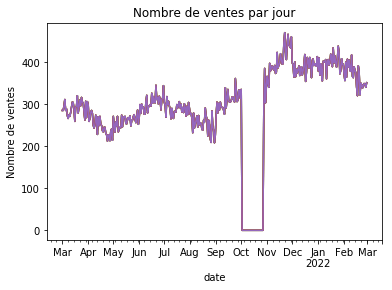

In [124]:
a= jointure[jointure['categ']==1]
a= a.groupby((pd.Grouper(key='date',freq='D')))
a = a.count().plot(legend=False)

plt.ylabel('Nombre de ventes')
plt.title('Nombre de ventes par jour')
plt.show(a)
image= a.get_figure()
image.savefig('Images/Nombre de ventes par jour')

### Conclusion de ce test : Nous avons ajouté les informations du produit 1_372 dans df_products_retraite_2 et avons ecarté le mois d'octobre de df_transaction car il nous manque des valeurs sur les produits de catégorie 1. 
cf = Test sur les valeurs aberrantes df_products et df_transactions

## Vérification de la présence de doublons.


In [19]:
mfct.verif_doublon(df_customers_retraite, namedf='customers')

Absence de doublon, il n'y a pas de retraitement à faire pour customers


In [20]:
mfct.verif_doublon(df_products_retraite_2, namedf='products')

Absence de doublon, il n'y a pas de retraitement à faire pour products


In [21]:
mfct.verif_doublon(df_transactions_retraite, namedf='transactions')

Absence de doublon, il n'y a pas de retraitement à faire pour transactions


## Conclusion du Nettoyage 
Pour notre analyse nous utiliserons df_customers_retraite, df_transactions_retraite_2 et df_products_retraite_2

# Mission n°2

Ensuite, vous réaliserez l’analyse des données. Une grande liberté vous est laissée sur ce plan, mais à vous de trouver les informations qui ont du sens pour mieux comprendre les ventes : 

Vous devrez y utiliser au moins :

    - des indicateurs de tendance centrale(mode, moyenne, mediane) et de dispersion (variance empirique, ecart-type, ecart inter-quartile)
    - une analyse de concentration, via une courbe de Lorenz et un indice de Gini
    - des représentations graphiques, dont au moins un histogramme, une représentation avec des "boites à moustaches", et une représentation de série temporelle (c’est à dire un graphique dont l’axe des abscisses représente des dates)
    - des analyses bivariées


## Tour d'horizon des variables à notre disposition
Les identifiants (clients, produits, transactions) sont des variables qualitatives :
 - Les codes sessions sont une variable qualitative ordinale (Ils sont ordonnés par date de transactions)
 - Les codes clients sont une variable qualitative nominale.(On ne peut pas dire que le client 1 est plus vieux que le client 300)
 - Les codes produits sont une variable qualitative ordinale.(Ils sont ordonés par categ 1 ou 0)
Les dates sont une variable qualitative ordinale car additionner des timestamp n'a pas de sens.
Les caratères categ et  sex sont des variables qualitatives ordinales
Les prix sont une variable quantitative car ces valeurs expriment une quantité et ont un sens lorsqu'on effectue des opérations arithmétiques dessus.

Informations qui ont du sens pour mieux comprendre les ventes :
- proportion des ventes par catégorie de produit
- montant des achats des clients
- évolution du chiffre d'affaires
- évolution du nombre d'achats

## Test : Construction tableau de distribution empirique et un pie chart pour la variable 'categ'

In [22]:
distribution_empirique_categ_products = mfct.distribution_empirique(df_products_retraite_2, variable='categ')
distribution_empirique_categ_products

,categ,n,f
0,0,2309,0.702464
1,1,739,0.224825
2,2,239,0.072711


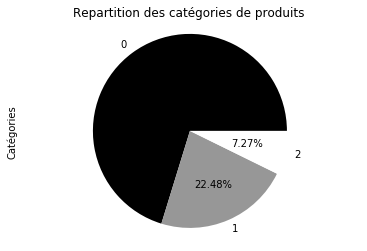

In [84]:
plot_distribution_empirique_categ_products = distribution_empirique_categ_products['f'].plot(kind='pie',autopct = lambda x: str(round(x, 2)) + '%', colormap='Greys_r')#Qu'est ce qui est stocké dans a ?
plt.axis('equal')
plt.ylabel('Catégories')
plt.title('Repartition des catégories de produits')
plt.show(plot_distribution_empirique_categ_products)
image= plot_distribution_empirique_categ_products.get_figure()
image.savefig('Images/Repartition des catégories de produits')

Les produits de catégorie 0 représentent 70% de l'ensemble des produits de l'entité

## Evolution du chiffre d'affaires

### Test
Recherche de valeurs manquantes suite jointure

In [24]:
# En faisant une jointure interne, il nous manque des lignes 340814 contre 341373 dans df_transactions_retraite. 
recherche_valeurs_manquante = pd.merge(df_transactions_retraite, df_products_retraite, 'outer') 

b= recherche_valeurs_manquante.shape
a=recherche_valeurs_manquante.isnull()
a= a[a['categ']==True]
c = recherche_valeurs_manquante.loc[250991,'id_prod']
print(b,a,c)
#--> Voir Test Supplémentaire

(341386, 6)         id_prod   date  session_id  client_id  price  categ
250433    False  False       False      False   True   True
250434    False  False       False      False   True   True
250435    False  False       False      False   True   True
250436    False  False       False      False   True   True
250437    False  False       False      False   True   True
250438    False  False       False      False   True   True
250439    False  False       False      False   True   True
250440    False  False       False      False   True   True
250441    False  False       False      False   True   True
250442    False  False       False      False   True   True
250443    False  False       False      False   True   True
250444    False  False       False      False   True   True
250445    False  False       False      False   True   True
250446    False  False       False      False   True   True
250447    False  False       False      False   True   True
250448    False  False      

In [25]:
df_transactions_retraite_mois = df_transactions_retraite_2.copy() #Copy du df pour travaux
df_jointure_trans_mois_prod = pd.merge(df_transactions_retraite_mois, df_products_retraite_2) #Jointure interne pour obtenir les infos des prix (df_prod) par rapport aux produits dans df_transac
df_ca_mois = df_jointure_trans_mois_prod.groupby(pd.Grouper(key='date',freq='M')).sum().reset_index() #Les données sont groupées par mois en les sommant


del df_ca_mois['categ'] #Suppression var categ
df_ca_mois.columns = ['mois','CA'] #Renommage des colonnes

df_ca_mois=df_ca_mois.drop([7])
df_ca_mois['CA'] = df_ca_mois['CA']/1000
df_ca_mois

,mois,CA
0,2021-03-31,479.81301
1,2021-04-30,473.49019
2,2021-05-31,489.66920
3,2021-06-30,481.84173
4,2021-07-31,481.53414
5,2021-08-31,479.77745
6,2021-09-30,484.95603
8,2021-11-30,513.68721
9,2021-12-31,523.63539
10,2022-01-31,523.75384


In [26]:
df_ca_mois['CA'].mean()

496.8706327272726

In [78]:
source = bk.ColumnDataSource(df_ca_mois) #Le df est converti en source pour le graphique bokeh
plot_df_ca_mois= bk.figure(plot_width=500, plot_height=500, x_axis_type='datetime', y_range=[300,550],title="Evolution du chiffre d'affaires en K euros")#Mise en forme

plot_df_ca_mois.line('mois','CA',source=source, color='grey') #Contenu
plot_df_ca_mois.xaxis.axis_label = "Periode en mois"
plot_df_ca_mois.yaxis.axis_label = "Chiffre d'affaires en K euros"
bk.show(plot_df_ca_mois)


In [28]:
df_transactions_retraite_mois_count_session = df_transactions_retraite_2.copy()
df_transactions_retraite_mois_count_session= df_transactions_retraite_mois_count_session.groupby(pd.Grouper(key='date', freq='M')).count().reset_index() #Les données sont groupées par mois en les comptant

del df_transactions_retraite_mois_count_session['id_prod'], df_transactions_retraite_mois_count_session['client_id']
df_transactions_retraite_mois_count_session =df_transactions_retraite_mois_count_session.drop([7])
df_transactions_retraite_mois_count_session

,date,session_id
0,2021-03-31,29013
1,2021-04-30,28897
2,2021-05-31,28693
3,2021-06-30,26947
4,2021-07-31,24951
5,2021-08-31,26049
6,2021-09-30,32531
8,2021-11-30,28684
9,2021-12-31,32890
10,2022-01-31,29549


In [29]:
df_transactions_retraite_mois_count_session['session_id'].mean()

28918.18181818182

In [79]:
source = bk.ColumnDataSource(df_transactions_retraite_mois_count_session)
plot_df_transactions_retraite_mois_count_session = bk.figure(plot_width=400, plot_height=400, x_axis_type='datetime', y_range=[20000,40000],title="Evolution du nombre de ventes")
plot_df_transactions_retraite_mois_count_session.line('date','session_id',source=source, color='rosybrown')
plot_df_transactions_retraite_mois_count_session.xaxis.axis_label = "Periode en mois"
plot_df_transactions_retraite_mois_count_session.yaxis.axis_label = "Nombre de ventes"
bk.show(plot_df_transactions_retraite_mois_count_session)

## Analyse des prix pratiqués : mode, mediane, moyenne

In [31]:
distribution_empirique_var_prix = mfct.distribution_empirique(df_jointure_trans_mois_prod, variable='price', freqcumul=True)
print(distribution_empirique_var_prix.head(10))

      price   n         f         F
1630   0.50   9  0.000028  0.000028
1816   0.51   6  0.000019  0.000047
2149   0.55   2  0.000006  0.000053
2107   0.56   2  0.000006  0.000060
2153   0.61   2  0.000006  0.000066
1848   0.62   5  0.000016  0.000082
1818   0.63   6  0.000019  0.000101
2009   0.66   3  0.000009  0.000110
1604   0.68  10  0.000031  0.000141
1866   0.77   5  0.000016  0.000157


### Le mode
Pour les variables qualitatives, ou pour les variables quantitatives discrètes, le mode est la modalité ou la valeur la plus fréquente.

In [32]:
df_jointure_trans_mois_prod['price'].mode()

0    13.86
dtype: float64

### La moyenne


In [33]:
df_jointure_trans_mois_prod['price'].mean()

17.181945803206535

### La mediane
La médiane, (notée Med), est la valeur telle que le nombre d’observations supérieures à cette valeur est égal au nombre d’observations inférieures à cette valeur.

In [34]:
df_jointure_trans_mois_prod['price'].median()

13.72

### La variance
Elle permet de savoir si les prix de ventes pratiqués sont très "resserrés" autour la moyenne des prix (17e). Une variance élevée indique que les valeurs sont très écartées les unes des autres, et vice versa. Elle est nulle lorsque toutes les valeurs sont identiques. Une variance n'est jamais négative.



In [35]:
df_jointure_trans_mois_prod['price'].var(ddof=0)

307.0245268891092

### L'écart type empirique 
C'est la racine carré de la variance. L'écart type est souvent plus parlant que la variance pour appréhender la dispersion.

In [36]:
df_jointure_trans_mois_prod['price'].std(ddof=0)

17.522115365705968

### L'écart inter-quartile
Il existe 3 quartiles, notés Q1 (premier quartile), Q2 (deuxième quartile) et Q3 (troisième quartile). Ainsi :

1/4 des valeurs se trouvent en dessous de Q1 et 3/4 au dessus

2/4 se trouvent en dessous de Q2, et 2/4 au dessus ( Q2est la médiane !)

3/4 se trouvent en dessous de Q3, et 1/4 au dessus

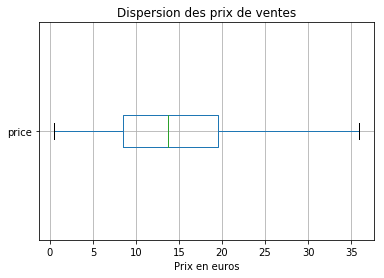

In [87]:
#boxprops = dict(linestyle='-',linewidth=3, color='k')
#flierprops = dict( markerfacecolor='red', markersize=13,linestyle='none')
#medianprops = dict(linestyle='-', linewidth=2.5, color='Greys')
plot_dispersion_prix =df_jointure_trans_mois_prod.boxplot(column="price",vert=False, showfliers=False)
plt.title('Dispersion des prix de ventes')
plt.xlabel('Prix en euros')
#Mise en évidence de l'écart inter quartile via le graphique de boite à moustache
plt.show()
image= plot_dispersion_prix.get_figure()
image.savefig('Images/Dispersion des prix de ventes')
# Ecart inter quartile = Q3 - Q1 
# Q1 = Extrémité gauche de la boite
# Q3 = Extrémité droite de la boite
# Extrémité gauche de la moustache = Q1 - 1.5IQ
# Extrémité droite de la moustache = Q3 - 1.5IQ
# Q2 = Mediane = Trait à l'intérieur de la boite
# Beaucoup trop d'outliers

In [38]:
median = np.median(df_jointure_trans_mois_prod['price'])
upper_quartile = np.percentile(df_jointure_trans_mois_prod['price'], 75)
lower_quartile = np.percentile(df_jointure_trans_mois_prod['price'], 25)

iqr = upper_quartile - lower_quartile
upper_whisker = df_jointure_trans_mois_prod['price'][df_jointure_trans_mois_prod['price']<=upper_quartile+1.5*iqr].max()
lower_whisker = df_jointure_trans_mois_prod['price'][df_jointure_trans_mois_prod['price']>=lower_quartile-1.5*iqr].min()
print("""La mediane est {}, Q1 est égal à {} et Q3 est égal à {} 
L'écart inter-quartile est égal à {} et les bornes sont respectivement de {} à {}""".format(median, lower_quartile,upper_quartile,iqr,lower_whisker,upper_whisker))

La mediane est 13.72, Q1 est égal à 8.54 et Q3 est égal à 19.48 
L'écart inter-quartile est égal à 10.940000000000001 et les bornes sont respectivement de 0.5 à 35.88


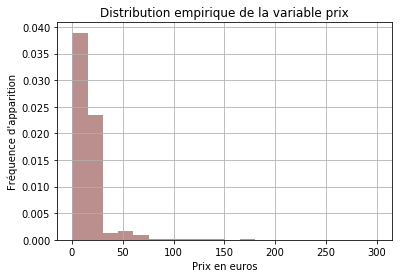

In [88]:
plot_distribution_empirique_prix =df_jointure_trans_mois_prod['price'].hist(density=True, bins=20,color='rosybrown') #l'effectif de la classe ne sera plus représenté par la hauteur du rectangle, mais par sa surface. Cela est dû au fait que les classes n'ont pas forcément la même largeur.
plt.title('Distribution empirique de la variable prix')
plt.xlabel('Prix en euros')
plt.ylabel("Fréquence d'apparition")
image= plot_distribution_empirique_prix.get_figure()
image.savefig('Images/Distribution empirique de la variable prix')

### La courbe de Lorenz
La courbe de Lorenz est la représentation graphique de la fonction qui, à la part x des détenteurs d'une part d'une grandeur, associe la part y de la grandeur détenue. Equivalent de Pareto (80/20)

In [40]:

distribution_empirique_var_prix['price']= pd.cut(distribution_empirique_var_prix['price'], 20)
distribution_empirique_var_prix = distribution_empirique_var_prix.groupby(['price']).sum().reset_index()
distribution_empirique_var_prix['F']=distribution_empirique_var_prix['f'].cumsum()
distribution_empirique_var_prix

,price,n,f,F
0,"(0.2, 15.475]",185389,0.582801,0.582801
1,"(15.475, 30.45]",111333,0.349994,0.932795
2,"(30.45, 45.425]",6301,0.019808,0.952603
3,"(45.425, 60.4]",7481,0.023518,0.976121
4,"(60.4, 75.375]",4219,0.013263,0.989384
5,"(75.375, 90.35]",413,0.001298,0.990682
6,"(90.35, 105.325]",546,0.001716,0.992399
7,"(105.325, 120.3]",472,0.001484,0.993882
8,"(120.3, 135.275]",450,0.001415,0.995297
9,"(135.275, 150.25]",311,0.000978,0.996275


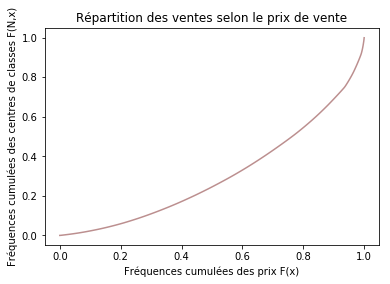

In [125]:
revenus = df_jointure_trans_mois_prod['price']
#Sélection du sous-échantillon de travail que l'on appelle  revenus
rev = revenus.values
#On place les observations dans une variable
lorenz = np.cumsum(np.sort(rev)) / rev.sum()
#Trie individus dans l'ordre croissant des valeurs de la variable, calcule de la somme cumulée et nomalisation en divisant par la somme des observations

lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

plot_lorenz = plt.figure()
plt.plot(np.linspace(0,1,len(lorenz)),lorenz,drawstyle='steps-post',color='rosybrown')
plt.title('Répartition des ventes selon le prix de vente')
plt.xlabel("Fréquences cumulées des prix F(x)")
plt.ylabel("Fréquences cumulées des centres de classes F(N,x)")
plt.show(plot_lorenz)


plot_lorenz.savefig('Images/Répartition des ventes selon le prix de vente')

### Indice de Gini
La courbe de Lorenz n'est pas une statistique, c'est une courbe ! Du coup, on a créé l'indice de Gini, qui résume la courbe de Lorenz.

Il mesure l'aire présente entre la première bissectrice et la courbe de Lorenz. Plus précisément, si on note S
cette aire, alors

In [91]:
aire_ss_courbe = lorenz[:-1].sum()/len(lorenz) # aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"

S = 0.5 - aire_ss_courbe # aire entre la 1e bissectrice et la courbe de Lorenz

gini = 2*S

gini

print("L'indice de Gini est égal à {}".format(gini))

L'indice de Gini est égal à 0.39063082372718383


## Analyse des produits

### Top 5 des produits qui se sont le plus vendus

In [43]:
distribution_empirique_var_prod= mfct.distribution_empirique(df_jointure_trans_mois_prod, variable='id_prod')
distribution_empirique_var_prod = distribution_empirique_var_prod.head(5)
print(distribution_empirique_var_prod)

  id_prod     n         f
0   1_434  1021  0.003210
1   1_429   988  0.003106
2     1_0   969  0.003046
3   1_428   959  0.003015
4   1_432   957  0.003008


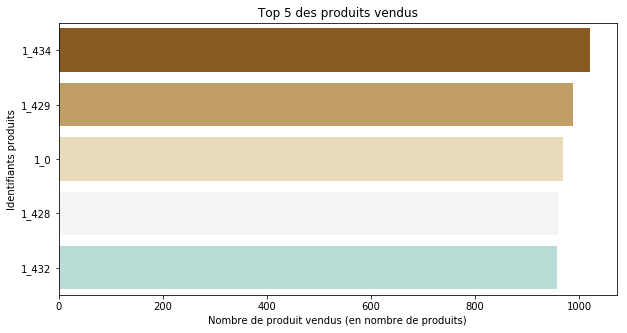

In [92]:
f, ax = plt.subplots(figsize=(10, 5))
my_plot = sns.barplot(x='n', y='id_prod',dodge=False, data=distribution_empirique_var_prod,orient='h', palette=sns.color_palette("BrBG", 7))
ax.set_xlabel('Nombre de produit vendus (en nombre de produits)')
ax.set_ylabel('Identifiants produits')

ax.set_title('Top 5 des produits vendus')
f.savefig('Images/Top 5 des produits vendus')

## Analyse de la structure des ventes

In [45]:
mfct.distribution_empirique(df_jointure_trans_mois_prod,variable='categ')


,categ,n,f
0,0,193820,0.609305
1,1,106653,0.335281
2,2,17627,0.055413


In [46]:
df_jointure_trans_mois_prod_mois_count_categ = df_jointure_trans_mois_prod.copy()
df_jointure_trans_mois_prod_mois_count_categ= df_jointure_trans_mois_prod_mois_count_categ.groupby([pd.Grouper(key='date', freq='M'),'categ']).count().reset_index()
df_jointure_trans_mois_prod_mois_count_categ['date']= df_jointure_trans_mois_prod_mois_count_categ['date'].dt.strftime('%Y-%m-%d')

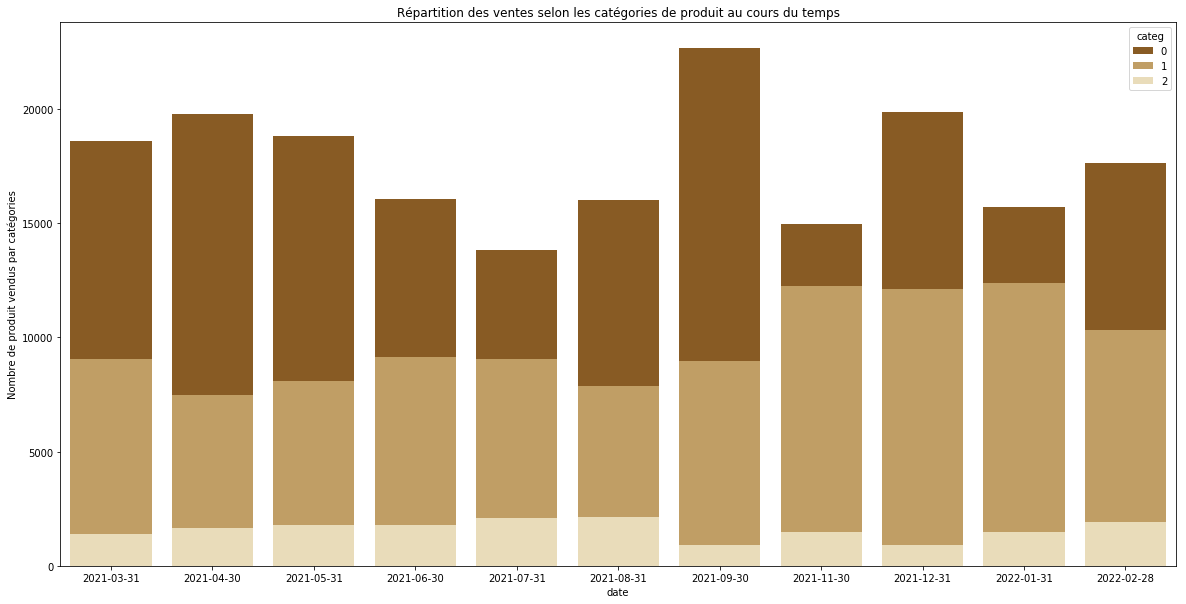

In [47]:
f, ax = plt.subplots(figsize=(20, 10))
my_plot = sns.barplot(x='date', y='session_id', hue='categ',dodge=False, data=df_jointure_trans_mois_prod_mois_count_categ, palette=sns.color_palette("BrBG", 7))
ax.set_ylabel('Nombre de produit vendus par catégories (en nombre de produits)')
ax.set_title('Répartition des ventes selon les catégories de produit au cours du temps')
f.savefig('Images/Répartition des ventes selon les catégories de produit au cours du temps')

### Répartition des prix pour chaque produit selon leur catégorie


In [48]:
df_products_retraite_prix_categ = df_products_retraite_2.copy()
df_products_retraite_prix_categ = df_products_retraite_prix_categ.groupby(['categ','id_prod']).sum().reset_index()
df_products_retraite_prix_categ0 = df_products_retraite_prix_categ[df_products_retraite_prix_categ['categ']==0]
df_products_retraite_prix_categ1 = df_products_retraite_prix_categ[df_products_retraite_prix_categ['categ']==1]
df_products_retraite_prix_categ2 = df_products_retraite_prix_categ[df_products_retraite_prix_categ['categ']==2]



/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


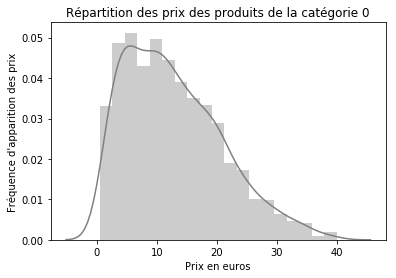

In [109]:
distrib_prix_categ0 = mfct.distribution_empirique(df_products_retraite_prix_categ0, variable='price', freqcumul=True)
f = plt.figure()

graph_distrib_categ0 = sns.distplot(distrib_prix_categ0['price'],color='grey')
graph_distrib_categ0.set_title('Répartition des prix des produits de la catégorie 0')
graph_distrib_categ0.set_xlabel('Prix en euros')
graph_distrib_categ0.set_ylabel("Fréquence d'apparition des prix")

f.savefig('Images/Répartition des prix des produits de la catégorie 0')
# ci-joint réponse au message d'erreur (https://github.com/MichaelGrupp/evo/issues/28)

In [50]:
df_products_retraite_prix_categ0['price'].mean()

11.637033347769599

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


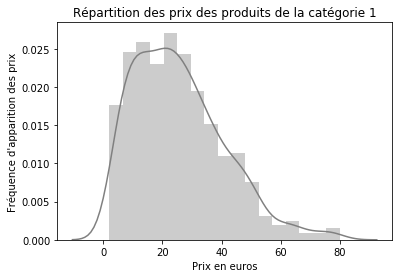

In [108]:
distrib_prix_categ1 = mfct.distribution_empirique(df_products_retraite_prix_categ1, variable='price', freqcumul=True)
f = plt.figure()

graph_distrib_categ1 = sns.distplot(distrib_prix_categ1['price'],color='grey')
graph_distrib_categ1.set_title('Répartition des prix des produits de la catégorie 1')
graph_distrib_categ1.set_xlabel('Prix en euros')
graph_distrib_categ1.set_ylabel("Fréquence d'apparition des prix")

f.savefig('Images/Répartition des prix des produits de la catégorie 1')


In [52]:
df_products_retraite_prix_categ1['price'].mean()

25.13726657645467

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


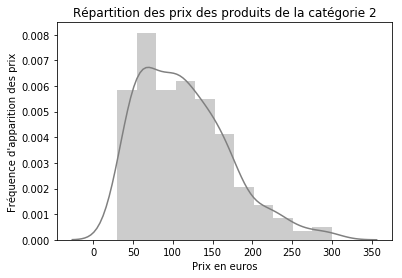

In [107]:
distrib_prix_categ2 = mfct.distribution_empirique(df_products_retraite_prix_categ2, variable='price', freqcumul=True)
f = plt.figure()
graph_distrib_categ2 = sns.distplot(distrib_prix_categ2['price'],color='grey')
graph_distrib_categ2.set_title('Répartition des prix des produits de la catégorie 2')
graph_distrib_categ2.set_xlabel('Prix en euros')
graph_distrib_categ2.set_ylabel("Fréquence d'apparition des prix")
f.savefig('Images/Répartition des prix des produits de la catégorie 2')


In [54]:
df_products_retraite_prix_categ2['price'].mean()

113.12205020920503

# Mission n°3

Voici quelques questions supplémentaires, que votre manager vous a posées :

    Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ?
    Y a-t-il une corrélation entre l'âge des clients et :
        le montant total des achats
        la fréquence d’achat
        la taille du panier moyen (en nombre d’articles)
        les catégories de produits achetés

Pour les corrélations, pas besoin d'effectuer en entier les tests (chi-2, ANOVA, etc.). Seul le calcul des statistiques de test est demandé ( r2,η2,ξn).

## Preparation des donnees


In [55]:
df_jointure_trans_mois_prod_clt = pd.merge(df_customers_retraite, df_jointure_trans_mois_prod) # Ajout des infos de df_customers à la jointure précédente (df_transac et df_prod)
df_jointure_trans_mois_prod_clt.head(10)



,client_id,sex,birth,id_prod,date,session_id,categ,price
0,c_1,f,1988,1_372,2021-03-26 15:17:26,s_743,1,25.00
1,c_1,f,1988,1_372,2022-01-31 04:01:34,s_9338,1,25.00
2,c_1,f,1988,0_1170,2021-04-12 04:57:55,s_1197,0,4.83
3,c_1,f,1988,0_1170,2022-01-01 21:36:19,s_8520,0,4.83
4,c_1,f,1988,0_1351,2021-04-14 12:36:40,s_1277,0,17.10
5,c_1,f,1988,0_1351,2021-07-27 00:15:35,s_4083,0,17.10
6,c_1,f,1988,0_1351,2021-12-19 17:16:11,s_8130,0,17.10
7,c_1,f,1988,0_1351,2022-01-14 21:26:45,s_8845,0,17.10
8,c_1,f,1988,0_1358,2021-04-07 17:28:12,s_1056,0,8.39
9,c_1,f,1988,0_1358,2021-05-14 17:01:25,s_2065,0,8.39


## Analyse des consommateurs

In [56]:
distribution_empirique_var_client = mfct.distribution_empirique(df_jointure_trans_mois_prod_clt, variable='client_id')
distribution_empirique_var_client = distribution_empirique_var_client.head(5)
print(distribution_empirique_var_client)

  client_id      n         f
0     c_508  25291  0.079506
1     c_510  13230  0.041591
2       c_3   2026  0.006369
3       c_6   1986  0.006243
4       c_1   1956  0.006149


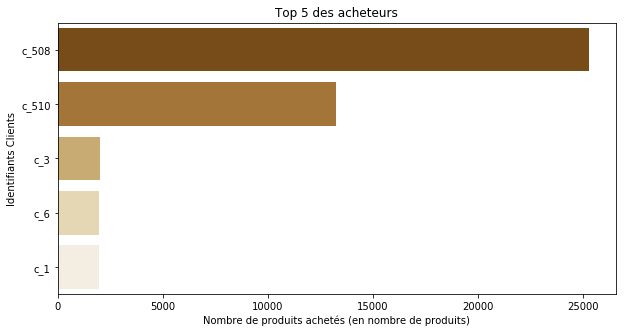

In [110]:
f, ax = plt.subplots(figsize=(10, 5))
my_plot = sns.barplot(x='n', y='client_id',dodge=False, data=distribution_empirique_var_client,orient='h', palette=sns.color_palette("BrBG", 10))
ax.set_xlabel('Nombre de produits achetés (en nombre de produits)')
ax.set_ylabel('Identifiants Clients')
ax.set_title('Top 5 des acheteurs')
f.savefig('Images/Top 5 des acheteurs')

Deux valeurs atypiques : 25K et 13K. Justification (collectivité territoriale, comité d'entreprise)

### Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ?


(categ         0         1        2     Total
 sex                                         
 f       88326.0   57936.0   9472.0  155734.0
 m      105494.0   48717.0   8155.0  162366.0
 total  193820.0  106653.0  17627.0  318100.0,
 categ         0         1         2
 f      0.199238  0.275112  0.036074
 m      0.191100  0.263875  0.034601)

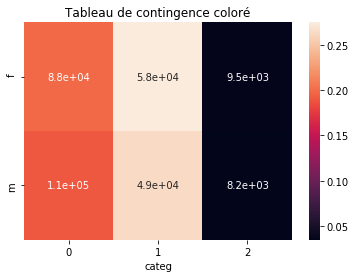

In [112]:
mfct.make_cont_tab(df_jointure_trans_mois_prod_clt, 'sex', 'categ', True)


Plus le 'xi' est proche de 0 plus la case est foncée et plus les variables sont indépendantes. Par exemple on ne peut pas dire qu'un homme achète plus de produits de catégorie 2 qu'une femme et inversement.
Pour chaque catégorie, il y a peu de nuance de teinte selon le sexe du client.

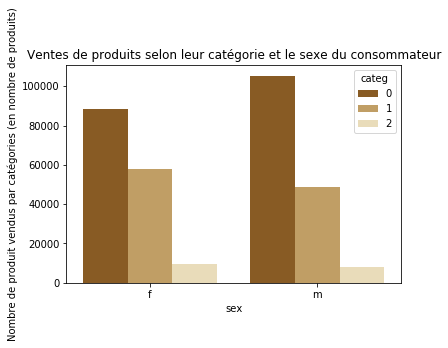

In [117]:
df_jointure_trans_mois_prod_clt_sex_categ = df_jointure_trans_mois_prod_clt.groupby(['sex','categ']).count().reset_index()
f= plt.figure()
plot_df_jointure_trans_mois_prod_clt_sex_categ = sns.barplot(x="sex", y="session_id",hue="categ", data=df_jointure_trans_mois_prod_clt_sex_categ, palette=sns.color_palette("BrBG", 7))
plot_df_jointure_trans_mois_prod_clt_sex_categ.set_title('Ventes de produits selon leur catégorie et le sexe du consommateur')
plot_df_jointure_trans_mois_prod_clt_sex_categ.set_ylabel('Nombre de produit vendus par catégories (en nombre de produits)')
f.savefig('Images/Ventes de produits selon leur catégorie et le sexe du consommateur')

### Y a-t-il une corrélation entre l'âge des clients et le montant total des achats (qte,qte)

In [119]:
df_jointure_trans_mois_prod_clt_birth = df_jointure_trans_mois_prod_clt.groupby('birth').sum().reset_index()
del df_jointure_trans_mois_prod_clt_birth['categ']
df_jointure_trans_mois_prod_clt_birth['age'] = 2022-df_jointure_trans_mois_prod_clt_birth['birth']

df_jointure_trans_mois_prod_clt_birth['price'] = df_jointure_trans_mois_prod_clt_birth['price']/1000
df_jointure_trans_mois_prod_clt_birth.head(10)

,birth,price,age
0,1927,2.94488,95
1,1930,8.99825,92
2,1931,2.80431,91
3,1934,9.42292,88
4,1936,3.39330,86
5,1937,10.15199,85
6,1938,15.30869,84
7,1939,1.57640,83
8,1940,17.83665,82
9,1941,24.78771,81


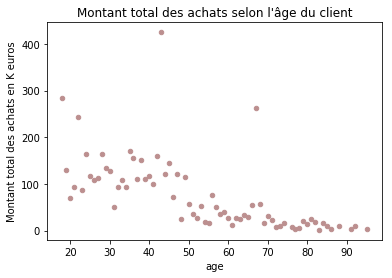

In [121]:

plot_df_jointure_trans_mois_prod_clt_birth =df_jointure_trans_mois_prod_clt_birth.plot(x="age",y="price", kind='scatter', color='rosybrown')
plt.xlabel("age")
plt.ylabel("Montant total des achats en K euros")
plt.title("Montant total des achats selon l'âge du client")
plt.show()
image= plot_df_jointure_trans_mois_prod_clt_birth.get_figure()
image.savefig("Images/Montant total des achats selon l'âge du client")

In [122]:
coef_corr_pearson = st.pearsonr(df_jointure_trans_mois_prod_clt_birth["age"],df_jointure_trans_mois_prod_clt_birth["price"])[0]
print(coef_corr_pearson)


-0.645995466096278


Le coefficient est négatif par conséquent, on peut émettre l'hypothèse que plus les consommateurs sont agés plus le montant total de leur achat est faible. Or le coefficient est plus proche de -1 que de zéro. Par conséquent, on peut affirmer que plus les consommateurs sont agés plus le montant total de leur achat est faible.(forte correlation)

### Y a-t-il une corrélation entre l'âge des clients et la fréquence d’achat (qte,qte)


In [63]:
df_jointure_trans_mois_prod_clt_birth = df_jointure_trans_mois_prod_clt.groupby('birth').count().reset_index()

df_jointure_trans_mois_prod_clt_birth['age'] = 2022-df_jointure_trans_mois_prod_clt_birth['birth']
n = df_jointure_trans_mois_prod_clt_birth.price.sum()
df_jointure_trans_mois_prod_clt_birth['price'] = df_jointure_trans_mois_prod_clt_birth['price']/n
df_jointure_trans_mois_prod_clt_birth.drop(['birth', 'client_id','sex','id_prod','session_id', 'categ','date'], axis = 1, inplace = True)
df_jointure_trans_mois_prod_clt_birth.head(10)


,price,age
0,0.000484,95
1,0.001430,92
2,0.000390,91
3,0.001415,88
4,0.000538,86
5,0.001484,85
6,0.002323,84
7,0.000280,83
8,0.002716,82
9,0.003713,81


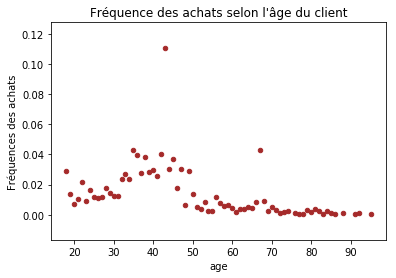

In [64]:
plot_df_jointure_trans_mois_prod_clt_birth= df_jointure_trans_mois_prod_clt_birth.plot(x="age",y="price", kind='scatter',color='brown')
plt.xlabel("age")
plt.ylabel("Fréquences des achats")
plt.title("Fréquence des achats selon l'âge du client")

plt.show()
image= plot_df_jointure_trans_mois_prod_clt_birth.get_figure()
image.savefig("Images/Fréquence des achats selon l'âge du client")

In [65]:
coef_corr_pearson = st.pearsonr(df_jointure_trans_mois_prod_clt_birth["age"],df_jointure_trans_mois_prod_clt_birth["price"])[0]
print(coef_corr_pearson)
p_value= coef_corr_pearson = st.pearsonr(df_jointure_trans_mois_prod_clt_birth["age"],df_jointure_trans_mois_prod_clt_birth["price"])[1]
print(p_value)


-0.4702961731899878
3.0664154751387645e-05


Ici, la correlation est quasiment égale à 0,5. Il faut dont comparer la p-value (ici 0,00306%) avec notre seuil de significativité (traditionnellement 5%). Dans notre cas la p-value est inférieure à notre seuil, donc on rejette l'hypothèse nulle en faveur de l’hypothèse alternative, et le résultat du test est déclaré « statistiquement significatif ». L'hypothèse alternative cette hypothèse suggère que la relation entre X et Y ne peut être attribuée au hasard; il existe donc un lien entre X et Y au sein de la population.(ici la correlation est moyenne)
Par conséquent, on peut affirmer que plus les consommateurs sont agés plus la fréquence de leurs achats est faible

### Y a-t-il une corrélation entre l'âge des clients et la taille du panier moyen (en nombre d’articles) (qte, qte)

In [66]:
df_jointure_trans_mois_prod_clt_birth_session = df_jointure_trans_mois_prod_clt.groupby(['birth','session_id']).count().reset_index()
df_jointure_trans_mois_prod_clt_birth = df_jointure_trans_mois_prod_clt_birth_session.groupby('birth').mean().reset_index()
df_jointure_trans_mois_prod_clt_birth['age'] = 2022-df_jointure_trans_mois_prod_clt_birth['birth']
df_jointure_trans_mois_prod_clt_birth.drop(['birth', 'client_id','sex','price', 'categ','date'], axis = 1, inplace = True)
df_jointure_trans_mois_prod_clt_birth.head(10)



,id_prod,age
0,1.026667,95
1,1.045977,92
2,1.008130,91
3,1.053864,88
4,1.030120,86
5,1.067873,85
6,1.112952,84
7,1.059524,83
8,1.109114,82
9,1.164694,81


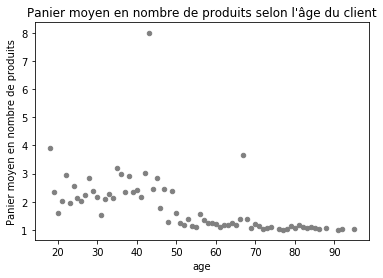

In [67]:
plot_df_jointure_trans_mois_prod_clt_birth=df_jointure_trans_mois_prod_clt_birth.plot(x="age",y="id_prod", kind='scatter',color='grey')
plt.xlabel("age")
plt.ylabel("Panier moyen en nombre de produits")
plt.title("Panier moyen en nombre de produits selon l'âge du client")

plt.show()
image= plot_df_jointure_trans_mois_prod_clt_birth.get_figure()
image.savefig("Images/Panier moyen en nombre de produits selon l'âge du client")

In [68]:
coef_corr_pearson = st.pearsonr(df_jointure_trans_mois_prod_clt_birth["age"],df_jointure_trans_mois_prod_clt_birth["id_prod"])[0]
print(coef_corr_pearson)
p_value= coef_corr_pearson = st.pearsonr(df_jointure_trans_mois_prod_clt_birth["age"],df_jointure_trans_mois_prod_clt_birth["id_prod"])[1]
print(p_value)


-0.5499243346736742
5.628972178744937e-07


Ici, la correlation est quasiment égale à 0,5. Il faut dont comparer la p-value (ici 0,00006%) avec notre seuil de significativité (traditionnellement 5%). Dans notre cas la p-value est inférieure à notre seuil, donc on rejette l'hypothèse nulle en faveur de l’hypothèse alternative, et le résultat du test est déclaré « statistiquement significatif ». L'hypothèse alternative cette hypothèse suggère que la relation entre X et Y ne peut être attribuée au hasard; il existe donc un lien entre X et Y au sein de la population.(ici la correlation est moyenne)
Par conséquent, on peut affirmer que plus les consommateurs sont agés plus le panier moyen en nombre de produit est faible

### Y a-t-il une corrélation entre l'âge des clients et les catégories de produits achetés (qte, qual)


In [69]:
b = df_jointure_trans_mois_prod_clt.groupby(['birth','categ']).count().reset_index()
b['age'] = 2022-b['birth']
b.drop(['birth', 'client_id','sex','id_prod', 'price','date'], axis = 1, inplace = True)
b.head(10)

,categ,session_id,age
0,0,22,95
1,1,130,95
2,2,2,95
3,0,62,92
4,1,384,92
5,2,9,92
6,0,13,91
7,1,107,91
8,2,4,91
9,0,49,88


In [70]:
#indice de Huntsberger : Pour connaitre le nombre ideal de classes pour la distribution

#N(cl) = 1 + 3,3 log10(N)
#N = nombre d’observations
#N(cl) = nombre de classes
nombre_classe = 1 + 3.3*mth.log10(215)
nombre_classe

8.697046917721497

In [71]:
b['age']= pd.cut(b['age'], 9)
b = b.groupby(['age','categ']).sum().reset_index()
b.head(10)

,age,categ,session_id
0,"(17.923, 26.556]",0,13556
1,"(17.923, 26.556]",1,16166
2,"(17.923, 26.556]",2,11753
3,"(26.556, 35.111]",0,40174
4,"(26.556, 35.111]",1,14760
5,"(26.556, 35.111]",2,4651
6,"(35.111, 43.667]",0,89224
7,"(35.111, 43.667]",1,18803
8,"(35.111, 43.667]",2,125
9,"(43.667, 52.222]",0,43247


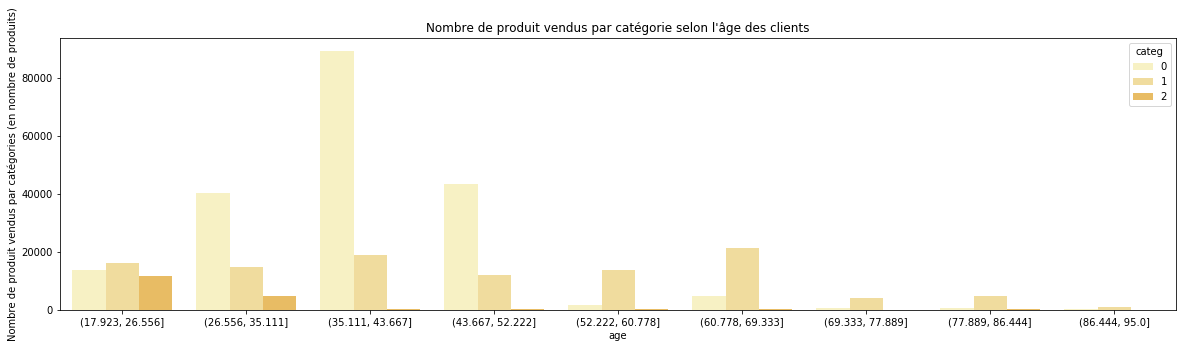

In [123]:
f,ax =plt.subplots(figsize=(20, 5))
a = sns.barplot(x="age", y="session_id",hue="categ", data=b, palette=sns.color_palette("YlOrBr", 7))
ax.set_title("Nombre de produit vendus par catégorie selon l'âge des clients")
ax.set_ylabel('Nombre de produit vendus par catégories (en nombre de produits)')
f.savefig("Images/Nombre de produit vendus par catégorie selon l'âge des clients")

In [73]:
df = df_jointure_trans_mois_prod_clt.copy()
df['age']= 2022-df['birth']
mfct.make_cont_tab(df, 'age', 'categ')


categ,0,1,2,Total
age,,,,
18,3124.0,3658.0,2559.0,9341.0
19,1503.0,1687.0,1123.0,4313.0
20,728.0,939.0,623.0,2290.0
21,1203.0,1302.0,778.0,3283.0
22,1862.0,2577.0,2399.0,6838.0
23,1108.0,1163.0,723.0,2994.0
24,1671.0,1940.0,1528.0,5139.0
25,1251.0,1521.0,1039.0,3811.0
26,1106.0,1379.0,981.0,3466.0


In [74]:
mfct.eta_squared(df['age'],df['categ'])

0.34915758591488616

Ici l'age des consommateurs et le type de catégorie de produits achetés sont très peu corrélés.